# Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts Using Java.*



# Setup

First, let's make sure this notebook works well in :

In [1]:
%maven commons-io:commons-io:jar:2.6
%maven io.vavr:vavr:jar:0.10.0
%maven org.apache.commons:commons-compress:1.18
    
    
import org.apache.commons.io.*;
import java.io.*;
import io.vavr.control.*;
import org.apache.commons.compress.archivers.tar.*;
import org.apache.commons.compress.compressors.gzip.*;

var DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/";
var HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz";
var PROJECT_ROOT_DIR = ".";
var CHAPTER_ID = "end_to_end_project";
var HOUSING_PATH = FilenameUtils.concat("datasets", "housing");
var BUFFER_SIZE = 1024;
void fetch_housing_data(String housingUrl, File housingPath){
   housingUrl = Objects.toString(housingUrl,HOUSING_URL);
   Objects.requireNonNull(housingPath);
   if(!housingPath.exists()){
       Try.run(() -> FileUtils.forceMkdir(housingPath));
   }
   var tgzPath = new File(FilenameUtils.concat(housingPath.getPath(), "housing.tgz"));
   var urlTemp = housingUrl;
   Try.run(() -> FileUtils.copyURLToFile(new URL(urlTemp), tgzPath )); 
   Try.run(() -> extractTarGZ(tgzPath, housingPath) );
}

void extractTarGZ(File in, File destDir) throws Exception {
    GzipCompressorInputStream gzipIn = new GzipCompressorInputStream(new FileInputStream(in));
    try (TarArchiveInputStream tarIn = new TarArchiveInputStream(gzipIn)) {
        TarArchiveEntry entry;

        while ((entry = (TarArchiveEntry) tarIn.getNextEntry()) != null) {
            /** If the entry is a directory, create the directory. **/
            if (entry.isDirectory()) {
                File f = new File(FilenameUtils.concat(destDir.getPath(),entry.getName()));
                boolean created = f.mkdir();
                if (!created) {
                    System.out.printf("Unable to create directory '%s', during extraction of archive contents.\n",
                            f.getAbsolutePath());
                }
            } else {
                int count;
                byte data[] = new byte[BUFFER_SIZE];
                FileOutputStream fos = new FileOutputStream(FilenameUtils.concat(destDir.getPath(),entry.getName()), false);
                try (BufferedOutputStream dest = new BufferedOutputStream(fos, BUFFER_SIZE)) {
                    while ((count = tarIn.read(data, 0, BUFFER_SIZE)) != -1) {
                        dest.write(data, 0, count);
                    }
                }
            }
        }

    }
}


In [2]:
fetch_housing_data(HOUSING_URL, new File(HOUSING_PATH));

In [5]:
%maven org.datavec:datavec-api:1.0.0-beta3
%maven org.deeplearning4j:deeplearning4j-core:1.0.0-beta3
%maven org.nd4j:nd4j-native-platform:1.0.0-beta3

import org.datavec.api.records.reader.RecordReader;
import org.datavec.api.records.reader.impl.csv.CSVRecordReader;
import org.datavec.api.split.FileSplit;
import org.deeplearning4j.datasets.datavec.RecordReaderDataSetIterator;
import org.nd4j.linalg.dataset.api.iterator.DataSetIterator;
import org.nd4j.linalg.dataset.DataSet;


DataSet load_housing_data(File housingPathCsv){
    int batchSize = 1000;
    RecordReader rr = new CSVRecordReader(0, ',');
    Try.run(()->rr.initialize(new FileSplit(housingPathCsv)));

    DataSetIterator iter =  new RecordReaderDataSetIterator(rr,batchSize, 1, 1, true);
    return iter.next();
}


In [7]:

var housing = load_housing_data(new File(FilenameUtils.concat(HOUSING_PATH,"housing.csv")));
housing.features();

EvalException: For input string: "longitude"

In [27]:
//planning to replicate housing.info()
display(housing.cols());
display(housing.cols().types());

com.zavtech.morpheus.reference.XDataFrameColumns@1170ee71

java.util.stream.ReferencePipeline$3@437d0d29

58d0de81-a94c-4e5a-bd1f-5e872f15dc38

In [28]:
import java.util.stream.Collectors;


display(housing.cols().select("ocean_proximity").colAt(0).toValueStream().collect(Collectors.groupingBy(string -> string, Collectors.counting())));
housing.rows().groupBy("ocean_proximity").forEach(0, (groupKey, group) -> {
    System.out.printf("There are %s rows for group %s\n", group.rowCount(), groupKey);
});
housing.rows().groupBy("ocean_proximity").stats(0).count().rows().sort(true).out().print(formats -> {
    formats.setDecimalFormat("0;-0", 1);
});

{INLAND=6551, ISLAND=5, NEAR BAY=2290, NEAR OCEAN=2658, <1H OCEAN=9136}

There are 6551 rows for group (INLAND)
There are 9136 rows for group (<1H OCEAN)
There are 5 rows for group (ISLAND)
There are 2290 rows for group (NEAR BAY)
There are 2658 rows for group (NEAR OCEAN)

    Index      |  longitude  |  latitude  |  housing_median_age  |  total_rooms  |  total_bedrooms  |  population  |  households  |  median_income  |  median_house_value  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  (<1H OCEAN)  |       9136  |      9136  |                9136  |         9136  |            9034  |        9136  |        9136  |           9136  |                9136  |
     (INLAND)  |       6551  |      6551  |                6551  |         6551  |            6496  |        6551  |        6551  |           6551  |                6551  |
     (ISLAND)  |          5  |         5  |                   5  |            5  |               5  |     

In [29]:
import com.zavtech.morpheus.stats.StatType;
housing.cols().describe(StatType.COUNT ,StatType.MAX ,StatType.MEAN ,StatType.MIN, StatType.STD_DEV  ).out().print();



       Index         |    COUNT     |      MAX      |       MEAN        |     MIN      |      STD_DEV      |
------------------------------------------------------------------------------------------------------------
          longitude  |  20640.0000  |       0.0000  |    -119.56970446  |   -124.3500  |       2.00353172  |
           latitude  |  20640.0000  |      41.9500  |      35.63186143  |     32.5400  |        2.1359524  |
 housing_median_age  |  20640.0000  |      52.0000  |      28.63948643  |      1.0000  |      12.58555761  |
        total_rooms  |  20640.0000  |   39320.0000  |     2635.7630814  |      2.0000  |    2181.61525158  |
     total_bedrooms  |  20433.0000  |    6445.0000  |     537.87055254  |      1.0000  |     421.38507007  |
         population  |  20640.0000  |   35682.0000  |    1425.47674419  |      3.0000  |    1132.46212177  |
         households  |  20640.0000  |    6082.0000  |     499.53968023  |      1.0000  |     382.32975283  |
      median_incom

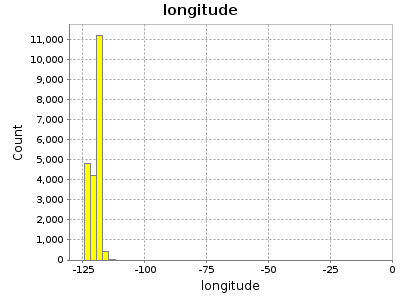

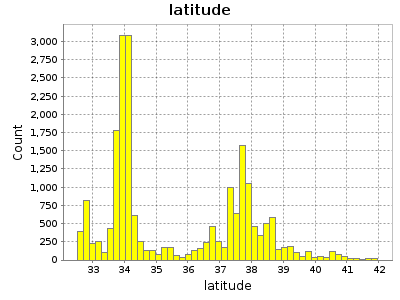

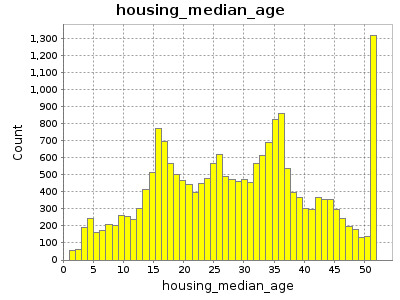

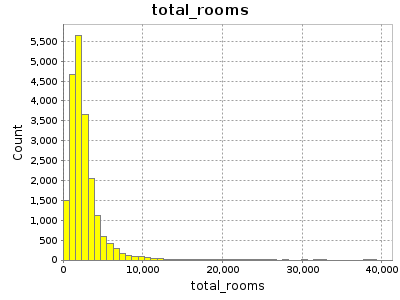

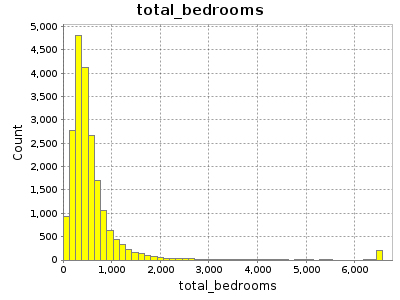

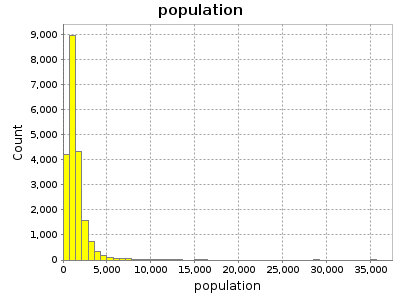

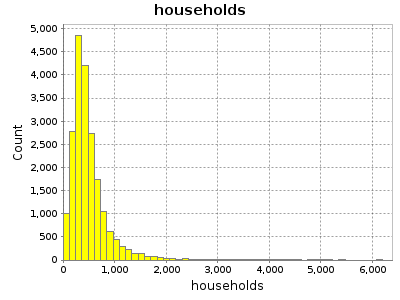

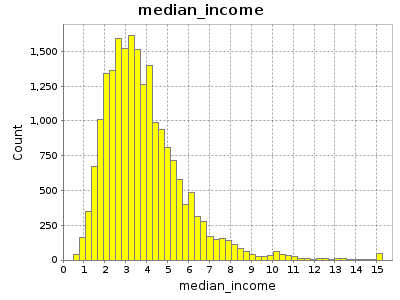

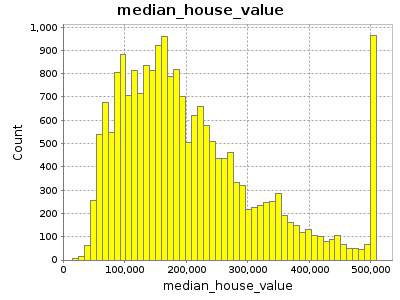

In [30]:
import com.zavtech.morpheus.viz.chart.*;
import javax.imageio.ImageIO;
import java.awt.Color;

housing.cols().stream().filter(p -> !Objects.toString(p.key(),"").equals("ocean_proximity"))
    .forEach(f ->{
        Chart.create().withHistPlot(f.toDataFrame(), 50, chart -> {
        chart.plot().axes().domain().label().withText(f.key());
        chart.plot().axes().range(0).label().withText("Count");
        chart.title().withText(f.key());
        chart.plot().style(f.key()).withLineWidth(2f).withColor(Color.YELLOW);
        //chart.subtitle().withText("Cumulative Sum of Random Uniform Data");
        //chart.legend().on();
        ByteArrayOutputStream output = new ByteArrayOutputStream();

        chart.writerPng(output, 400,300, false);
        display(Try.of(()-> ImageIO.read(new ByteArrayInputStream(output.toByteArray()))).get());
    });
});


In [31]:
import io.vavr.*;
import java.util.stream.IntStream;

Tuple2<DataFrame<Integer,String>, DataFrame<Integer,String>> spliTrainTest(DataFrame<Integer,String> data, float testRatio){
    var indexes =
    IntStream.range(0, data.rowCount())                      // <-- creates a stream of ints
        .boxed()                               // <-- converts them to Integers
        .collect(Collectors.toList());          // <-- collects the values to a list

    Collections.shuffle(indexes, new Random(42));
    var testSize = Math.round(data.rowCount() * testRatio);
    var colArrayKeys = data.cols().keyArray();
    return Tuple.of(data.select(indexes.subList(0,  testSize), colArrayKeys), 
                    data.select(indexes.subList(testSize,  data.rowCount()), colArrayKeys)
                   );
}



In [32]:

var splitData = spliTrainTest(housing, 0.2f);
var testData = splitData._1;
var trainData = splitData._2; 
testData.rowCount() + " testData " + trainData.rowCount() + " trainData" 


4128 testData 16512 trainData

In [33]:
import java.security.MessageDigest;

boolean testSetCheck(String original,  float testRatio){
    MessageDigest md = Try.of(() -> MessageDigest.getInstance("MD5") ).get();
    md.update(original.getBytes());
    byte[] digest = md.digest();
    return digest[digest.length-1] > 256*testRatio;
}

Tuple2<DataFrame<Integer,String>, DataFrame<Integer,String>> spliTrainTestWithId(DataFrame<Integer,String> data, float testRatio, String idColumn){
    
    return Tuple.of(data.select(p -> testSetCheck( Objects.toString(p.getValue(idColumn)), testRatio), p -> true  ), 
                    data.select(p -> !testSetCheck( Objects.toString(p.getValue(idColumn)) ,testRatio), p -> true  )
                   );
}

In [34]:
var housingWithId = housing.cols().add("id", Double.class, v -> v.row().getDouble("longitude") * 1000 + v.row().getDouble("latitude"));
splitData = spliTrainTestWithId(housing, 0.2f,"id");
testData = splitData._1;
trainData = splitData._2;
testData.rowCount() + " testData " + trainData.rowCount() + " trainData" 

6066 testData 14574 trainData